In [1]:
# import libraries

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# import dataset

image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "C:/Users/USER/COE/Codes/style transfer/CNN Practice Exercise/New folder/train",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "C:/Users/USER/COE/Codes/style transfer/CNN Practice Exercise/New folder/test",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 249 files belonging to 3 classes.
Using 200 files for training.
Found 65 files belonging to 3 classes.
Using 13 files for validation.


In [3]:
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [4]:
class_names = train_ds.class_names
print(class_names)

['Covid', 'Normal', 'Viral Pneumonia']


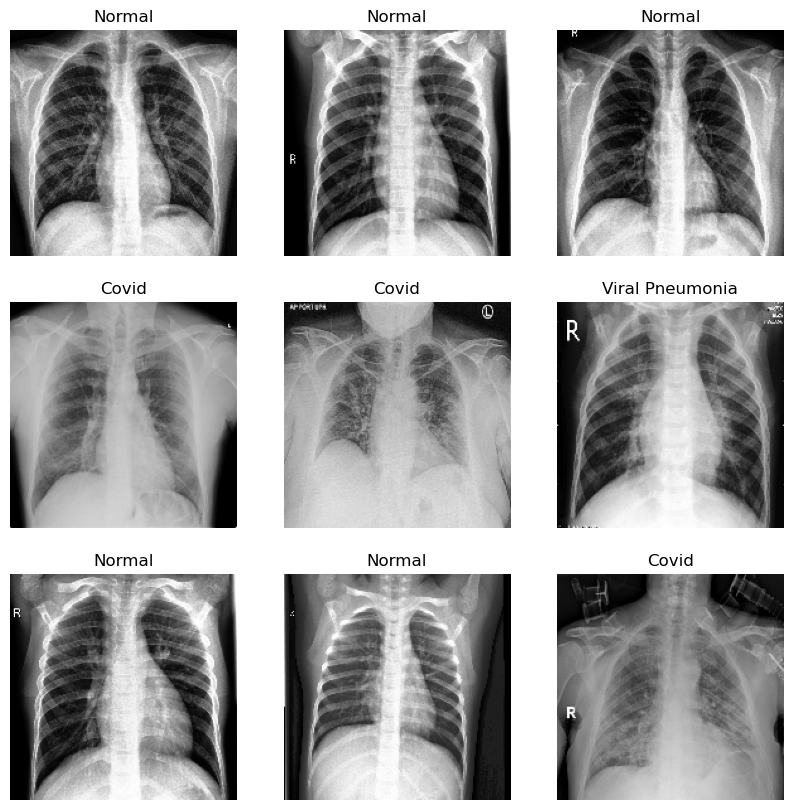

In [5]:
# visualization

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
# image data augmentation

data_augmentation = keras.Sequential(
    [
     layers.experimental.preprocessing.RandomFlip("horizontal"),
     layers.experimental.preprocessing.RandomRotation(0.05),
     layers.experimental.preprocessing.RandomZoom(0.10)
    ]
)

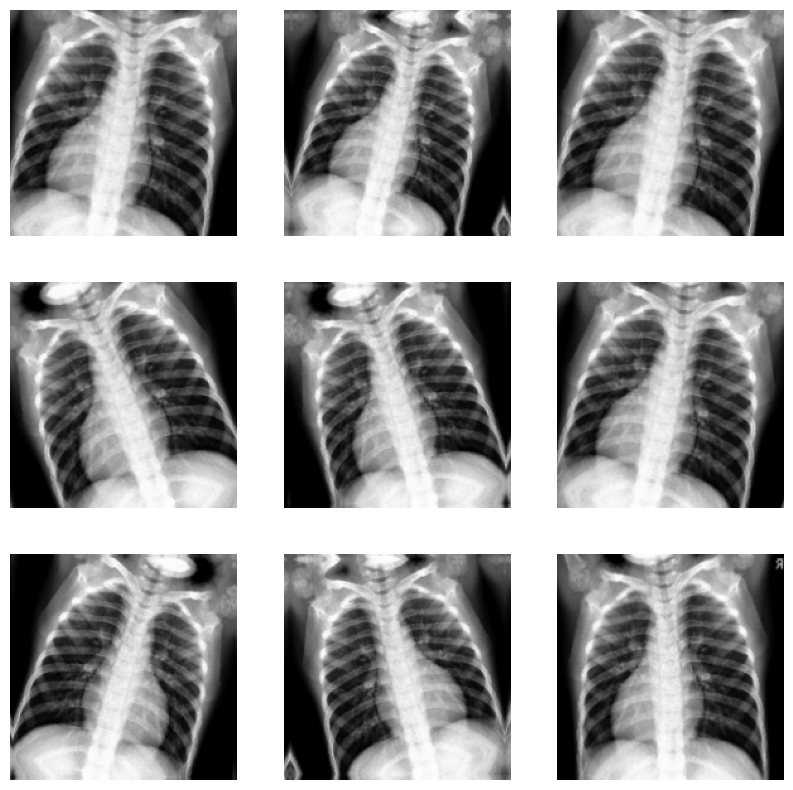

In [7]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [8]:
# configuration of the dataset for performance

train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

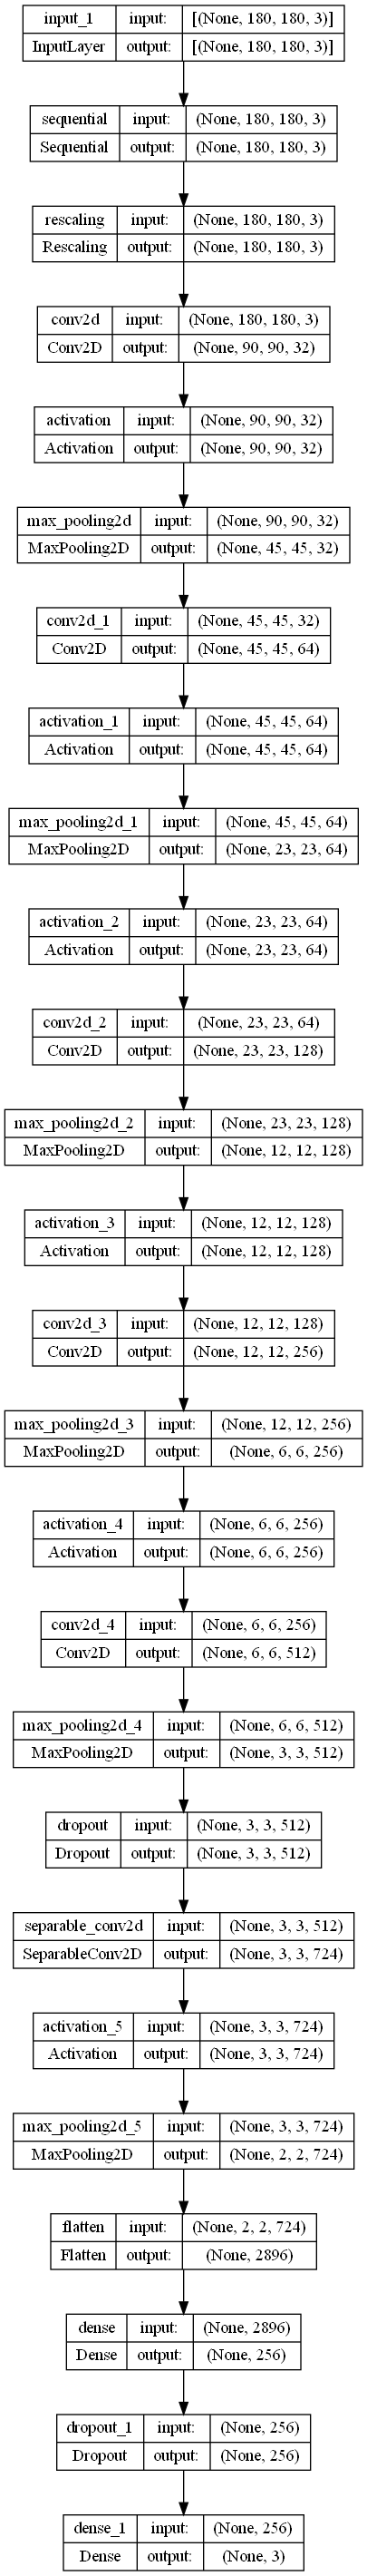

In [9]:
# model building

keras.backend.clear_session()

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    
    # image augmentation block
    x = data_augmentation(inputs)

    # entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 5, strides=2, padding="same")(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPool2D(3, strides=2, padding="same")(x)

    x = layers.Conv2D(64, 5, padding="same")(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPool2D(3, strides=2, padding="same")(x)

    for size in [128, 256, 512]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2D(size, 5, padding="same")(x)
        x = layers.MaxPool2D(3, strides=2, padding="same")(x)

    x = layers.Dropout(0.5)(x)
    x = layers.SeparableConv2D(724, 3, padding="same")(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPool2D(3, strides=2, padding="same")(x)

    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)

    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=3)
keras.utils.plot_model(model, show_shapes=True)

In [10]:
# callbacks

def scheduler(epoch, lr):
  if epoch < 9:
    return lr
  else:
    return lr * tf.math.exp(-0.008)

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [11]:
# train the model

epochs = 60

model.compile(optimizer= keras.optimizers.Adam(),
              loss = 'sparse_categorical_crossentropy',
              metrics = ["accuracy"])

history = model.fit(
    train_ds, epochs = epochs, 
    callbacks = [lr_callback],
    validation_data = val_ds)

Epoch 1/60
7/7 [==============================] - 23s 2s/step - loss: 1.3986 - accuracy: 0.3950 - val_loss: 1.0987 - val_accuracy: 0.3846 - lr: 0.0010
Epoch 2/60
7/7 [==============================] - 14s 2s/step - loss: 1.0993 - accuracy: 0.3050 - val_loss: 1.0974 - val_accuracy: 0.3846 - lr: 0.0010
Epoch 3/60
7/7 [==============================] - 15s 2s/step - loss: 1.0987 - accuracy: 0.4050 - val_loss: 1.0955 - val_accuracy: 0.3846 - lr: 0.0010
Epoch 4/60
7/7 [==============================] - 15s 2s/step - loss: 1.0905 - accuracy: 0.4650 - val_loss: 1.0696 - val_accuracy: 0.3846 - lr: 0.0010
Epoch 5/60
7/7 [==============================] - 15s 2s/step - loss: 1.1031 - accuracy: 0.3800 - val_loss: 1.0940 - val_accuracy: 0.3846 - lr: 0.0010
Epoch 6/60
7/7 [==============================] - 15s 2s/step - loss: 1.0887 - accuracy: 0.4350 - val_loss: 1.0929 - val_accuracy: 0.3846 - lr: 0.0010
Epoch 7/60
7/7 [==============================] - 15s 2s/step - loss: 1.0844 - accuracy: 0.445

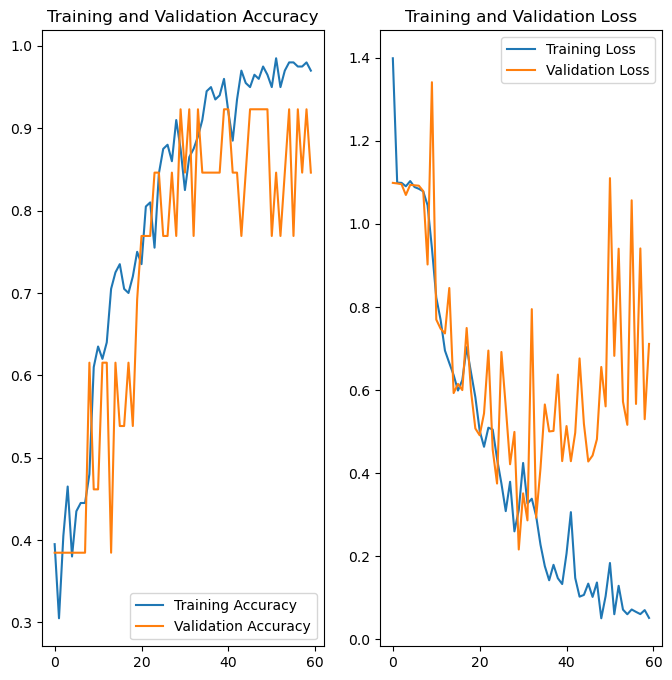

In [12]:
# visualization

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [13]:
# validation

image_path1 = "C:/Users/USER/COE/Codes/style transfer/CNN Practice Exercise/New folder/validation/pic1.jpeg"
image_path2 = "C:/Users/USER/COE/Codes/style transfer/CNN Practice Exercise/New folder/validation/pic2.jpeg"
image_path3 = "C:/Users/USER/COE/Codes/style transfer/CNN Practice Exercise/New folder/validation/pic3.jpeg"
image_path4 = "C:/Users/USER/COE/Codes/style transfer/CNN Practice Exercise/New folder/validation/pic4.jpeg"
image_path5 = "C:/Users/USER/COE/Codes/style transfer/CNN Practice Exercise/New folder/validation/pic5.jpeg"
image_path6 = "C:/Users/USER/COE/Codes/style transfer/CNN Practice Exercise/New folder/validation/pic6.jpeg"
image_path7 = "C:/Users/USER/COE/Codes/style transfer/CNN Practice Exercise/New folder/validation/pic7.jpg"
image_path8 = "C:/Users/USER/COE/Codes/style transfer/CNN Practice Exercise/New folder/validation/pic8.jpeg"
image_path9 = "C:/Users/USER/COE/Codes/style transfer/CNN Practice Exercise/New folder/validation/pic9.jpeg"
image_path10 = "C:/Users/USER/COE/Codes/style transfer/CNN Practice Exercise/New folder/validation/pic10.jpeg"
merged_path = [image_path1,image_path2,image_path3,image_path4,image_path5,image_path6,image_path7,image_path8,image_path9,image_path10]

for img_path in merged_path:
    img = keras.preprocessing.image.load_img(
        img_path, target_size=image_size)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    
    print(
        "The x-ray image is likely a {}"
        .format(class_names[np.argmax(score)], 100 * np.max(score)))

1/1 [==============================] - 0s 450ms/step
The x-ray image is likely a Normal
1/1 [==============================] - 0s 73ms/step
The x-ray image is likely a Covid
1/1 [==============================] - 0s 76ms/step
The x-ray image is likely a Viral Pneumonia
1/1 [==============================] - 0s 92ms/step
The x-ray image is likely a Normal
1/1 [==============================] - 0s 82ms/step
The x-ray image is likely a Normal
1/1 [==============================] - 0s 82ms/step
The x-ray image is likely a Covid
1/1 [==============================] - 0s 102ms/step
The x-ray image is likely a Covid
1/1 [==============================] - 0s 65ms/step
The x-ray image is likely a Covid
1/1 [==============================] - 0s 64ms/step
The x-ray image is likely a Covid
1/1 [==============================] - 0s 60ms/step
The x-ray image is likely a Normal
